# **Classify Waste Products Using Transfer Learning**

EcoClean currently lacks an efficient and scalable method to automate the waste sorting process. The manual sorting of waste is not only labor-intensive but also prone to errors, leading to contamination of recyclable materials. The goal of this project is to leverage machine learning and computer vision to automate the classification of waste products, improving efficiency and reducing contamination rates. The project will use transfer learning with a pre-trained VGG16 model to classify images.

The aim of the project is to develop an automated waste classification model that can accurately differentiate between recyclable and organic waste based on images. By the end of this project, you will have trained, fine-tuned, and evaluated a model using transfer learning, which can then be applied to real-world waste management processes.




- Apply transfer learning using the VGG16 model for image classification.
- Prepare and preprocess image data for a machine learning task.
- Fine-tune a pre-trained model to improve classification accuracy.
- Evaluate the model’s performance using appropriate metrics.
- Visualize model predictions on test data.

### Installing Required Libraries

In [1]:
!pip install tensorflow==2.17.0 | tail -n 1
!pip install numpy == 1.26.0 | tail -n 1
!pip install scikit-learn==1.5.1 | tail -n 1
!pip install matplotlib==3.9.2 | tail -n 1
!pip install tqdm

'tail' is not recognized as an internal or external command,
operable program or batch file.
'tail' is not recognized as an internal or external command,
operable program or batch file.
'tail' is not recognized as an internal or external command,
operable program or batch file.
'tail' is not recognized as an internal or external command,
operable program or batch file.


### Importing Required Libraries

In [19]:
import numpy as np 
import os
import glob

from matplotlib import pyplot as plt
from matplotlib.image import imread

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras import optimizers 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from sklearn import metrics
import warnings 
warnings.filterwarnings('ignore')


**Transfer learning** uses the concept of keeping the early layers of a pre-trained network, and re-training the later layers on a specific dataset. We can leverage some state of that network on a related task. 

A typical transfer learning workflow in Keras:

1. Initialize the base model, and load pre-trained weights (eg. ImageNet)
2. "Freeze" layers in the base model by setting `training = False`
3. Define a new model that goes on top of the output of the base model's layers. 
4. Train resulting model on our dataset. 

## Importing Data

In [4]:
import requests 
import zipfile
from tqdm import tqdm 

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/kd6057VPpABQ2FqCbgu9YQ/o-vs-r-split-reduced-1200.zip"
file_name = "o-vs-r-split-reduced-1200.zip"

print("Downloading file")
with requests.get(url, stream=True) as response:
    response.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)


def extract_file_with_progress(file_name):
    print("Extracting file with progress")
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        members = zip_ref.infolist() 
        with tqdm(total=len(members), unit='file') as progress_bar:
            for member in members:
                zip_ref.extract(member)
                progress_bar.update(1)
    print("Finished extracting file")


extract_file_with_progress(file_name)

print("Finished extracting file")
os.remove(file_name)

Extracting file with progress


100%|██████████| 1207/1207 [00:00<00:00, 1585.53file/s]

Finished extracting file
Finished extracting file


## Define configuration options

In [5]:
img_rows, img_cols = 150, 150
batch_size = 32
n_epochs = 15
n_classes = 2
val_split = 0.2
verbosity = 1
path = 'o-vs-r-split/train/'
path_test = 'o-vs-r-split/test/'
input_shape = (img_rows, img_cols, 3)
labels = ['O', 'R']
seed = 42

### ImageDataGenerators 

For augmentation.

In [8]:
train_datagen = ImageDataGenerator (
    validation_split = val_split, 
    rescale = 1.0/255.0,
    width_shift_range = 0.1,
    height_shift_range = 0.1, 
    horizontal_flip = True,
    vertical_flip = True
)

val_datagen = ImageDataGenerator (
    validation_split = val_split,
    rescale = 1.0/255.0,
)

test_datagen = ImageDataGenerator (
    rescale = 1.0 / 255.0
)


In [9]:
train_generator = train_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = True,
    target_size = (img_rows, img_cols),
    subset = 'training'
)

Found 800 images belonging to 2 classes.


In [10]:
val_generator = val_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'validation' 
)

Found 200 images belonging to 2 classes.


In [15]:
test_generator = test_datagen.flow_from_directory(
    directory = path_test,
    seed = seed,
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = False,
    target_size = (img_rows, img_cols),
)

Found 200 images belonging to 2 classes.


In [16]:
print(len(train_generator))

25


Looking at a few augmented images:

Labels: ['O', 'O', 'O', 'O', 'O']


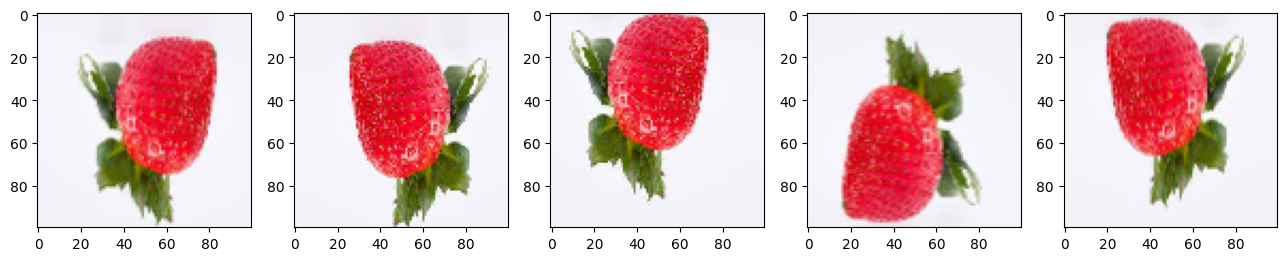

In [20]:
from pathlib import Path

IMG_DIM = (100, 100)

train_files = glob.glob('./o-vs-r-split/train/O/*')
train_files = train_files[:20]
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [Path(fn).parent.name for fn in train_files]

img_id = 0
O_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
O = [next(O_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in O])
l = [ax[i].imshow(O[i][0][0]) for i in range(0,5)]


### Pre-trained Model: VGG-16

In [21]:
from tensorflow.keras.applications import vgg16

input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

We flatten the output of a VGG model and assign it to the model `output`, we then use a Model object `basemodel` to group the layers into an object for training and inference. With the following inputs and outputs. 

inputs: `vgg.input`

outputs: `tf.keras.layers.Flatten()(output)`

In [22]:
output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

Next we freeze the basemodel.

In [23]:
for layer in basemodel.layers:
    layer.trainable = False

Create a new model on top. We add a Dropout layer for regularization, only these layers will change as for the lower layers we set `training=False` when calling the basemodel.

In [25]:
input_shape = basemodel.output_shape[1]

model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

## Print the summar of the model

In [26]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ (None, 8192)           │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,172,673 (73.14 MB)

 Trainable params: 4,457,985 (17.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Compile the model

In [28]:
for layer in basemodel.layers:
    layer.trainable = False

model.compile(
    loss="binary_crossentropy",
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    metrics = ['accuracy']
)

* Early stopping to avoid over-training the model

In [29]:
from tensorflow.keras.callbacks import LearningRateScheduler


checkpoint_path='O_R_tlearn_vgg16.keras'

# define step decay function
class LossHistory_(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(epoch))
        print('lr:', exp_decay(len(self.losses)))

def exp_decay(epoch):
    initial_lrate = 1e-4
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss', 
                    patience = 4, 
                    mode = 'min', 
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

## Fit and train the model

In [30]:
exact_feat_model = model.fit(
    train_generator,
    steps_per_epoch = 5,
    epochs = 10,
    callbacks = callbacks_list_,
    validation_data = val_generator,
    validation_steps = val_generator.samples // batch_size,
    verbose = 1
)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accuracy: 0.5298 - loss: 0.7963lr: 9.048374180359596e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5332 - loss: 0.7858 - val_accuracy: 0.6562 - val_loss: 0.6143 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 975ms/step - accuracy: 0.6425 - loss: 0.6387lr: 8.187307530779819e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.6438 - loss: 0.6355 - val_accuracy: 0.7240 - val_loss: 0.5564 - learning_rate: 9.0484e-05
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - accuracy: 0.6711 - loss: 0.5689lr: 7.408182206817179e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6780 - loss: 0.5634 - val_accuracy: 0.7396 - val_loss: 0.4990 - learning_rate: 8.1873e-05
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 841ms/step - accuracy: 0.7039 - loss: 0.5685lr: 6.703200460356394e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7074 - loss: 0.5648 - val_accuracy: 0.8490 - val_loss: 0.4392 - learning_rate: 7.4082e-05
Ep

## Plot loss curves for training and validation sets 

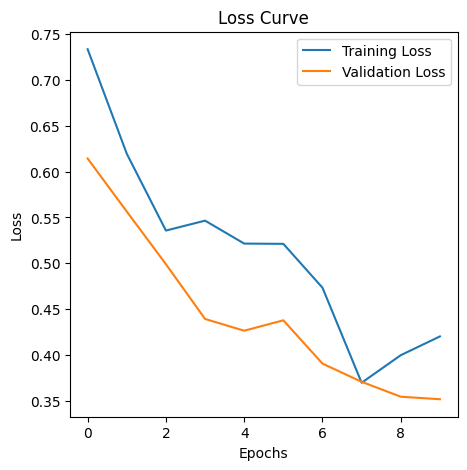

In [32]:
import matplotlib.pyplot as plt

history = exact_feat_model

plt.figure(figsize=(5,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Plot accuracy curves for training and validation sets

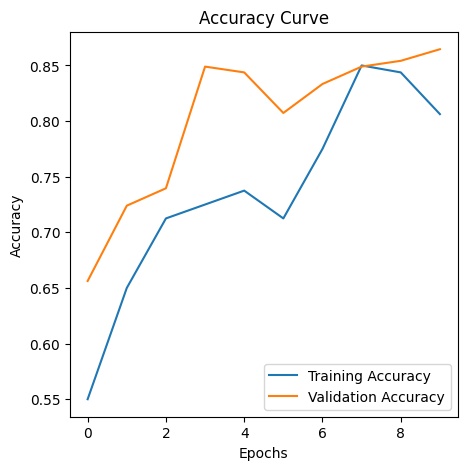

In [35]:
import matplotlib.pyplot as plt

history = exact_feat_model
## Task 6: Plot accuracy curves for training and validation sets

# plot loss curve
plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


## Fine-Tuning model

We will unfreeze one later from the base model and train the model again.

In [36]:
from tensorflow.keras.applications import vgg16

input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

for layer in basemodel.layers:
    layer.trainable = False

display([layer.name for layer in basemodel.layers])

set_trainable = False

for layer in basemodel.layers :
    if layer.name in ['blocks5_conv3']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in basemodel.layers:
    print(f"{layer.name}: {layer.trainable}")

['input_layer_2',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'flatten_1']

input_layer_2: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: False
block5_conv2: False
block5_conv3: False
block5_pool: False
flatten_1: False


We will create a new model on top, and add a Dropout layer for regularization.

In [37]:
model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

checkpoint_path='O_R_tlearn_fine_tune_vgg16.keras'

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss', 
                    patience = 4, 
                    mode = 'min', 
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

fine_tune_model = model.fit(train_generator, 
                    steps_per_epoch=5, 
                    epochs=10,
                    callbacks = callbacks_list_,   
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples // batch_size, 
                    verbose=1)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 847ms/step - accuracy: 0.5384 - loss: 0.7665lr: 9.048374180359596e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5497 - loss: 0.7584 - val_accuracy: 0.7812 - val_loss: 0.5644 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 945ms/step - accuracy: 0.7073 - loss: 0.5974lr: 8.187307530779819e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7040 - loss: 0.5958 - val_accuracy: 0.7604 - val_loss: 0.5328 - learning_rate: 9.0484e-05
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.7802 - loss: 0.5151lr: 7.408182206817179e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7804 - loss: 0.5163 - val_accuracy: 0.7500 - val_loss: 0.4969 - learning_rate: 8.1873e-05
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.7429 - loss: 0.5059lr: 6.703200460356394e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.7451 - loss: 0.5060 - val_accuracy: 0.7760 - val_loss: 0.4650 - learning_rate: 7.4082e-05


## Plot loss curves for training and validation sets (fine tune model)

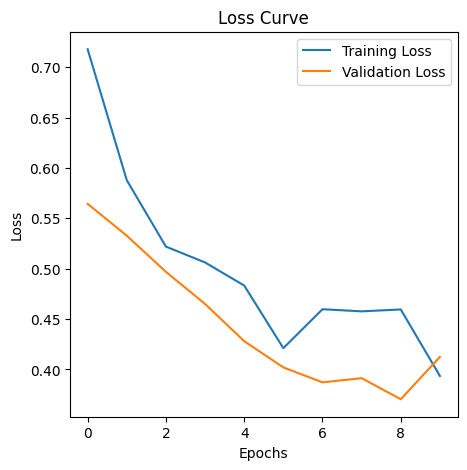

In [38]:
history = fine_tune_model

## Task 7: Plot loss curves for training and validation sets (fine tune model)

# plot loss curve
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Plot accuract vurves for training and validation sets (fine tune model)

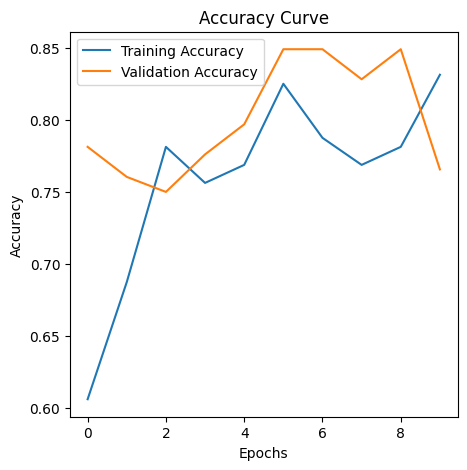

In [39]:
history = fine_tune_model

# Task 8: Plot accuracy curves for training and validation sets  (fine tune model)

# plot loss curve
plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Evaluate both models on test data

In [40]:
from pathlib import Path

# Load saved models
extract_feat_model = tf.keras.models.load_model('O_R_tlearn_vgg16.keras')
fine_tune_model = tf.keras.models.load_model('O_R_tlearn_fine_tune_vgg16.keras')

IMG_DIM = (150, 150)

# Load test images
test_files_O = glob.glob('./o-vs-r-split/test/O/*')
test_files_R = glob.glob('./o-vs-r-split/test/R/*')
test_files = test_files_O[:50] + test_files_R[:50]

test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [Path(fn).parent.name for fn in test_files]

# Standardize
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

class2num_lt = lambda l: [0 if x == 'O' else 1 for x in l]
num2class_lt = lambda l: ['O' if x < 0.5 else 'R' for x in l]

test_labels_enc = class2num_lt(test_labels)

# Make predictions for both models
predictions_extract_feat_model = extract_feat_model.predict(test_imgs_scaled, verbose=0)
predictions_fine_tune_model = fine_tune_model.predict(test_imgs_scaled, verbose=0)

# Convert predictions to class labels
predictions_extract_feat_model = num2class_lt(predictions_extract_feat_model)
predictions_fine_tune_model = num2class_lt(predictions_fine_tune_model)

# Print classification report for both models
print('Extract Features Model')
print(metrics.classification_report(test_labels, predictions_extract_feat_model))
print('Fine-Tuned Model')
print(metrics.classification_report(test_labels, predictions_fine_tune_model))


Extract Features Model
              precision    recall  f1-score   support

           O       0.74      0.84      0.79        50
           R       0.81      0.70      0.75        50

    accuracy                           0.77       100
   macro avg       0.78      0.77      0.77       100
weighted avg       0.78      0.77      0.77       100

Fine-Tuned Model
              precision    recall  f1-score   support

           O       0.74      0.86      0.80        50
           R       0.83      0.70      0.76        50

    accuracy                           0.78       100
   macro avg       0.79      0.78      0.78       100
weighted avg       0.79      0.78      0.78       100



[Accuracy actually declined]

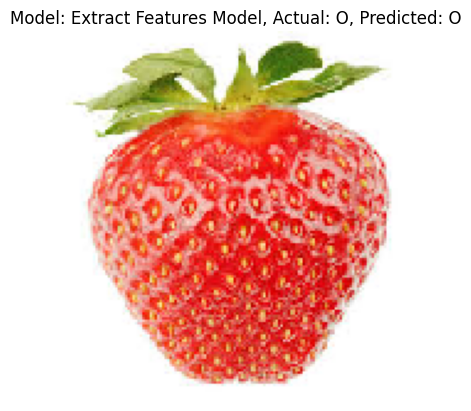

In [41]:
# Plot one of the images with actual label and predicted label as title
def plot_image_with_title(image, model_name, actual_label, predicted_label):
    plt.imshow(image)
    plt.title(f"Model: {model_name}, Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

# Specify index of image to plot, for example index 0
index_to_plot = 0
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot], 
    predicted_label=predictions_extract_feat_model[index_to_plot],
    )

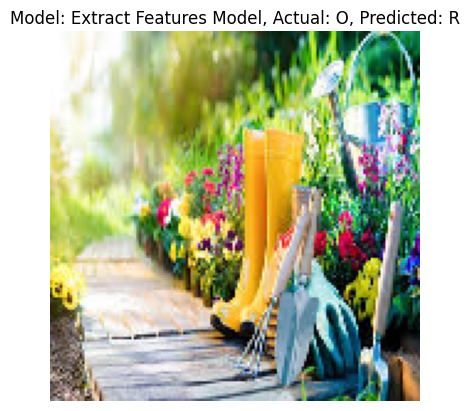

In [42]:
# Task 9: Plot a test image using Extract Features Model (index_to_plot = 1)
index_to_plot = 1
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot], 
    predicted_label=predictions_extract_feat_model[index_to_plot],
    )

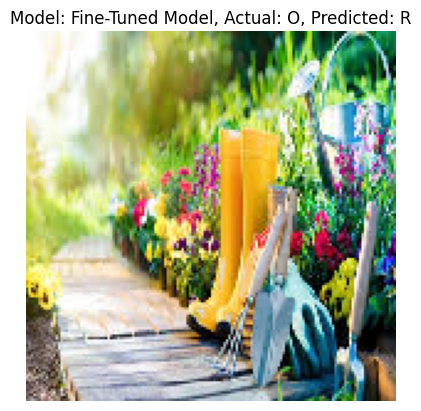

In [43]:
# Task 10: Plot a test image using Fine-Tuned Model (index_to_plot = 1)
index_to_plot = 1
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Fine-Tuned Model',
    actual_label=test_labels[index_to_plot], 
    predicted_label=predictions_fine_tune_model[index_to_plot],
    )

Both got them wrong.